In [1]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from gbc_encoder import NeuralEncoder, Neural3DEncoder, NeuralEncoderDeep, Neural3DEncoderDeep
import pandas as pd
import matplotlib.pyplot as plt

# Load the data and set the device
DATA_SOURCE_PATH = '../../data/processed/pscalar/neural_gbc_nn.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv(DATA_SOURCE_PATH)
PANSS_selector = list(data.columns[data.columns.str.contains('PANSS')])

# Encode the group labels
le = LabelEncoder()
group_labels = data['Group'].to_numpy()
group_labels = le.fit_transform(group_labels)

## 2D Embeddings

In [ ]:
# Wrap the PyTorch model in a skorch estimator

early_stopping = EarlyStopping(monitor='valid_loss', patience=5, threshold=0.0001)

net = NeuralNetRegressor(
    NeuralEncoder,
    max_epochs=150,
    lr=0.01,
    device=device,  # 'cuda' or 'cpu'
    callbacks=[early_stopping],
    criterion=nn.MSELoss,
    optimizer=Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    verbose=False
)

# Define the hyperparameters for the grid search
param_grid = {
    'lr': [0.1, 0.01, 0.001, 0.0001],
    'module__activation': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
}

# Define the grid search
gs_2d_shallow = GridSearchCV(net, param_grid, refit=True, cv=5, scoring='neg_mean_squared_error')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=PANSS_selector+['id','Group']), data[PANSS_selector], test_size=0.2)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

# Perform the grid search
gs_2d_shallow.fit(X_train, y_train)
print(gs_2d_shallow.best_score_, gs_2d_shallow.best_params_)

-0.9420868396759033 {'lr': 0.001, 'module__activation': ELU(alpha=1.0)}


In [3]:
neural_encoder_2d_shallow = gs_2d_shallow.best_estimator_.module_
X = data.drop(columns=PANSS_selector+['id','Group'])
embeddings_2d_shallow = neural_encoder_2d_shallow.generate_embedding(X.to_numpy())

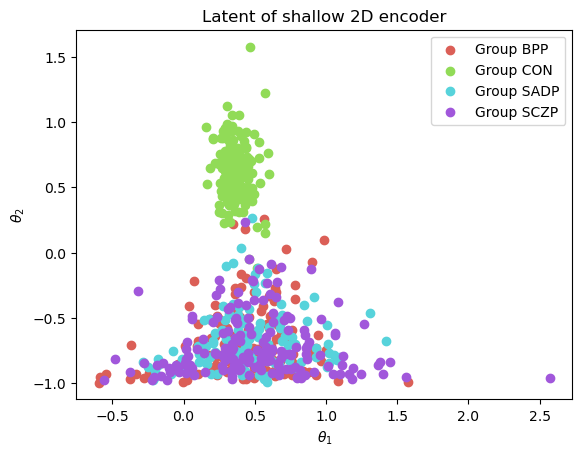

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.tight_layout()

# Create a color palette with 4 colors
palette = sns.color_palette("hls", 4)

# Create the scatter plot
for i in range(4):
    # Get the encoded inputs for this group
    group_inputs = embeddings_2d_shallow[group_labels == i]

    original_string = le.inverse_transform([i])[0]

    # Plot the encoded inputs for this group
    plt.scatter(group_inputs[:, 0], group_inputs[:, 1], color=palette[i], label=f'Group {original_string}')

# Show the plot
plt.legend()
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Latent space of shallow 2D encoder')
plt.savefig('../final_report/figures/shallow_2d_encoder.svg')
plt.show()

---


## 3D Embeddings

In [32]:
# Wrap the PyTorch model in a skorch estimator

early_stopping = EarlyStopping(monitor='valid_loss', patience=5, threshold=0.0001)

net = NeuralNetRegressor(
    Neural3DEncoder,
    max_epochs=150,
    lr=0.01,
    device=device,  # 'cuda' or 'cpu'
    callbacks=[early_stopping],
    criterion=nn.MSELoss,
    optimizer=Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    verbose=False
)

# Define the hyperparameters for the grid search
param_grid = {
    'lr': [0.1, 0.01, 0.001, 0.0001],
    'module__activation': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
}

gs_3d_shallow = GridSearchCV(net, param_grid, refit=True, cv=5, scoring='neg_mean_squared_error')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=PANSS_selector+['id','Group']), data[PANSS_selector], test_size=0.2)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

# Perform the grid search
gs_3d_shallow.fit(X_train, y_train)
print(gs_3d_shallow.best_score_, gs_3d_shallow.best_params_)

-0.9598335146903991 {'lr': 0.01, 'module__activation': ELU(alpha=1.0)}


In [33]:
neural_encoder_3d_shallow = gs_3d_shallow.best_estimator_.module_
X = data.drop(columns=PANSS_selector+['id','Group'])
embeddings_3d_shallow = neural_encoder_3d_shallow.generate_embedding(X.to_numpy())

In [35]:
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Create a new figure
fig = plt.figure()
plt.tight_layout()

# Create a color palette with 4 colors
palette = sns.color_palette("hls", 4)

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
for i in range(4):
    # Get the encoded inputs for this group
    group_inputs = embeddings_3d_shallow[group_labels == i]

    original_string = le.inverse_transform([i])[0]

    # Plot the encoded inputs for this group
    ax.scatter(group_inputs[:, 0], group_inputs[:, 1], group_inputs[:, 2], color=palette[i], label=f'Group {original_string}')

# Show the plot

ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'$\theta_3$')
plt.title('Latent space of shallow 3D encoder')

plt.legend()
plt.show()

---

# Deeper Networks

## 2D embeddings

In [7]:
# Wrap the PyTorch model in a skorch estimator

early_stopping = EarlyStopping(monitor='valid_loss', patience=5, threshold=0.0001)

net = NeuralNetRegressor(
    NeuralEncoderDeep,
    max_epochs=150,
    lr=0.01,
    device=device,  # 'cuda' or 'cpu'
    callbacks=[early_stopping],
    criterion=nn.MSELoss,
    optimizer=Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    verbose=False
)

# Define the hyperparameters for the grid search
param_grid = {
    'lr': [0.001],#[0.1, 0.01, 0.001, 0.0001],
    'module__activation': [nn.ELU(alpha=1.0)],#[nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
}

# Define the grid search
gs_2d_deep = GridSearchCV(net, param_grid, refit=True, cv=5, scoring='neg_mean_squared_error')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=PANSS_selector+['id','Group']), data[PANSS_selector], test_size=0.2)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

# Perform the grid search
gs_2d_deep.fit(X_train, y_train)
print(gs_2d_deep.best_score_, gs_2d_deep.best_params_)

-0.9161828875541687 {'lr': 0.001, 'module__activation': ELU(alpha=1.0)}


In [8]:
neural_encoder_2d_deep = gs_2d_deep.best_estimator_.module_
X = data.drop(columns=PANSS_selector+['id','Group'])
embeddings_2d_deep = neural_encoder_2d_deep.generate_embedding(X.to_numpy())

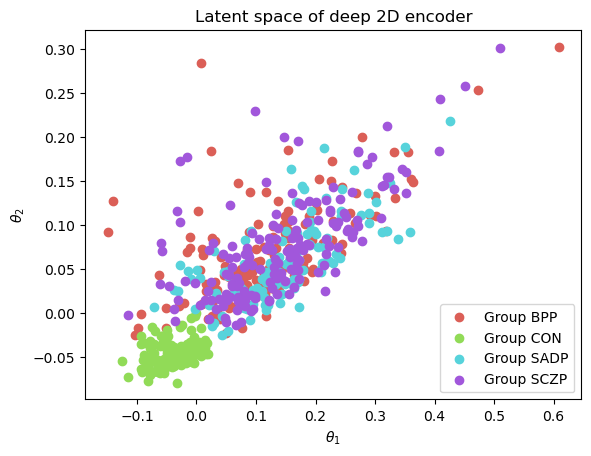

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.tight_layout()

# Create a color palette with 4 colors
palette = sns.color_palette("hls", 4)

# Create the scatter plot
for i in range(4):
    # Get the encoded inputs for this group
    group_inputs = embeddings_2d_deep[group_labels == i]

    original_string = le.inverse_transform([i])[0]

    # Plot the encoded inputs for this group
    plt.scatter(group_inputs[:, 0], group_inputs[:, 1], color=palette[i], label=f'Group {original_string}')

# Show the plot

plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Latent space of deep 2D encoder')
plt.legend()
plt.savefig('../final_report/figures/deep_2d_encoder.svg')
plt.show()

## 3D embeddings

In [ ]:
# Wrap the PyTorch model in a skorch estimator

early_stopping = EarlyStopping(monitor='valid_loss', patience=5, threshold=0.0001)

net = NeuralNetRegressor(
    Neural3DEncoderDeep,
    max_epochs=150,
    lr=0.01,
    device=device,  # 'cuda' or 'cpu'
    callbacks=[early_stopping],
    criterion=nn.MSELoss,
    optimizer=Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    verbose=False
)

# Define the hyperparameters for the grid search
param_grid = {
    'lr': [0.1, 0.01, 0.001, 0.0001],
    'module__activation': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
}

# Define the grid search
gs_3d_deep = GridSearchCV(net, param_grid, refit=True, cv=5, scoring='neg_mean_squared_error')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=PANSS_selector+['id','Group']), data[PANSS_selector], test_size=0.2)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

# Perform the grid search
gs_3d_deep.fit(X_train, y_train)
print(gs_3d_deep.best_score_, gs_3d_deep.best_params_)

-0.9013686418533325 {'lr': 0.001, 'module__activation': ELU(alpha=1.0)}


In [ ]:
neural_encoder_3d_deep = gs_3d_deep.best_estimator_.module_
X = data.drop(columns=PANSS_selector+['id','Group'])
embeddings_3d_deep = neural_encoder_3d_deep.generate_embedding(X.to_numpy())

In [ ]:
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Create a new figure
fig = plt.figure()
plt.tight_layout()

# Create a color palette with 4 colors
palette = sns.color_palette("hls", 4)

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
for i in range(4):
    # Get the encoded inputs for this group
    group_inputs = embeddings_3d_deep[group_labels == i]

    original_string = le.inverse_transform([i])[0]

    # Plot the encoded inputs for this group
    ax.scatter(group_inputs[:, 0], group_inputs[:, 1], group_inputs[:, 2], color=palette[i], label=f'Group {original_string}')

# Show the plot

ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'$\theta_3$')
plt.title('Latent space of deep 3D encoder')

plt.legend()
plt.show()